# Предобработка данных и инженерия признаков для предсказания стоимости аренды квартир

В этом ноутбуке проведем инженерию признаков (Feature Engineering) для улучшения предсказания стоимости аренды квартир.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_palette('Set2')

import warnings
warnings.filterwarnings('ignore')

## 1. Загрузка предобработанных данных

Загружаем данные, полученные после 2-го релиза (очистка от пропусков).

In [2]:
# Загружаем данные из второго релиза
df = pd.read_csv('../data/edited_data.csv')

# Проверяем размерность и просматриваем первые строки
print(f"Размерность данных: {df.shape}")
df.head()

Размерность данных: (19737, 8)


,id_listing,number_of_rooms,metro_on_foot,area_m2,building_info,price,renovation,bathroom
0,271271157,4,9,200,2,500000,3,0
1,271634126,4,8,198,3,500000,3,1
2,271173086,4,7,200,1,500000,2,1
3,272197456,4,3,170,1,400000,2,1
4,273614615,2,7,58,0,225000,2,0


## 2. Создание новых признаков (Feature Engineering)

Создадим новые признаки, которые помогут улучшить предсказания модели.

### 2.1. Признаки на основе цены

In [3]:
# Цена за квадратный метр
df['price_per_m2'] = df['price'] / df['area_m2']

# Цена за комнату
df['price_per_room'] = df['price'] / df['number_of_rooms']

# Просмотрим созданные признаки
df[['area_m2', 'number_of_rooms', 'price', 'price_per_m2', 'price_per_room']].head()

,area_m2,number_of_rooms,price,price_per_m2,price_per_room
0,200,4,500000,2500.000000,125000.0
1,198,4,500000,2525.252525,125000.0
2,200,4,500000,2500.000000,125000.0
3,170,4,400000,2352.941176,100000.0
4,58,2,225000,3879.310345,112500.0


### 2.2. Категориальные признаки на основе метро


In [4]:
# Создаем категории удаленности от метро
def categorize_metro_distance(minutes):
    if minutes <= 5:
        return 0  # Очень близко
    elif minutes <= 10:
        return 1  # Близко
    elif minutes <= 15:
        return 2  # Средне
    elif minutes <= 25:
        return 3  # Далеко
    else:
        return 4  # Очень далеко

# Применяем функцию
df['metro_category'] = df['metro_on_foot'].apply(categorize_metro_distance)

# Бинарный признак: в пешей доступности от метро (≤ 10 минут)
df['is_walk_distance'] = (df['metro_on_foot'] <= 10).astype(int)

# Просмотрим созданные признаки
df[['metro_on_foot', 'metro_category', 'is_walk_distance']].head(10)

,metro_on_foot,metro_category,is_walk_distance
0,9,1,1
1,8,1,1
2,7,1,1
3,3,0,1
4,7,1,1
5,5,0,1
6,4,0,1
7,3,0,1
8,9,1,1
9,10,1,1


### 2.3. Признаки на основе площади


In [5]:
# Статистика по площади
area_stats = df['area_m2'].describe()
print(area_stats)

# Определим пороги для маленьких и больших квартир (25-й и 75-й процентили)
small_threshold = area_stats['25%']
large_threshold = area_stats['75%']

# Бинарный признак для маленьких квартир
df['is_small_area'] = (df['area_m2'] <= small_threshold).astype(int)

# Бинарный признак для больших квартир
df['is_large_area'] = (df['area_m2'] >= large_threshold).astype(int)

# Площадь на комнату
df['area_per_room'] = df['area_m2'] / df['number_of_rooms']

# Просмотрим созданные признаки
df[['area_m2', 'number_of_rooms', 'is_small_area', 'is_large_area', 'area_per_room']].head()

count    19737.000000
mean        63.516796
std         47.953921
min          7.000000
25%         38.000000
50%         49.000000
75%         70.000000
max        811.000000
Name: area_m2, dtype: float64


,area_m2,number_of_rooms,is_small_area,is_large_area,area_per_room
0,200,4,0,1,50.0
1,198,4,0,1,49.5
2,200,4,0,1,50.0
3,170,4,0,1,42.5
4,58,2,0,0,29.0


### 2.4. Категории цен


In [6]:
# Статистика по ценам
price_stats = df['price'].describe()
print(price_stats)

# Определим пороги для категорий цен
low_threshold = price_stats['25%']
high_threshold = price_stats['75%']
very_high_threshold = price_stats['75%'] + (price_stats['75%'] - price_stats['25%'])

# Создаем категории цен
def categorize_price(price):
    if price <= low_threshold:
        return 0  # Бюджетное жилье
    elif price <= high_threshold:
        return 1  # Среднее по цене
    elif price <= very_high_threshold:
        return 2  # Дорогое жилье
    else:
        return 3  # Премиум жилье

# Применяем функцию
df['price_category'] = df['price'].apply(categorize_price)

# Просмотрим созданный признак
df[['price', 'price_category']].head(10)

count    1.973700e+04
mean     8.656385e+04
std      1.281483e+05
min      5.000000e+03
25%      3.999000e+04
50%      5.000000e+04
75%      7.500000e+04
max      3.000000e+06
Name: price, dtype: float64


,price,price_category
0,500000,3
1,500000,3
2,500000,3
3,400000,3
4,225000,3
5,470000,3
6,350000,3
7,250000,3
8,130000,3
9,210000,3


### 2.5. Комбинированные признаки


In [7]:
# Комбинация типа здания и ремонта
df['building_renovation'] = df['building_info'] * 10 + df['renovation']

# Комбинация близости к метро и типа здания
df['metro_building'] = df['metro_category'] * 10 + df['building_info']

# Просмотрим созданные признаки
df[['building_info', 'renovation', 'building_renovation', 'metro_category', 'metro_building']].head()

,building_info,renovation,building_renovation,metro_category,metro_building
0,2,3,23,1,12
1,3,3,33,1,13
2,1,2,12,1,11
3,1,2,12,0,1
4,0,2,2,1,10


### 2.6. Номинализация категориальных признаков в числовой форме

In [8]:
# Проверим типы данных всех признаков
df.dtypes

id_listing               int64
number_of_rooms          int64
metro_on_foot            int64
area_m2                  int64
building_info            int64
price                    int64
renovation               int64
bathroom                 int64
price_per_m2           float64
price_per_room         float64
metro_category           int64
is_walk_distance         int64
is_small_area            int64
is_large_area            int64
area_per_room          float64
price_category           int64
building_renovation      int64
metro_building           int64
dtype: object

## 3. Проверка данных на соответствие требованиям


In [18]:
# Проверка на пропущенные значения
print("Проверка на пропущенные значения:")
print(df.isna().sum())

# Проверка на дубликаты
print(f"\nКоличество дубликатов: {df.duplicated().sum()}")

Проверка на пропущенные значения:
id_listing             0
number_of_rooms        0
metro_on_foot          0
area_m2                0
building_info          0
price                  0
renovation             0
bathroom               0
price_per_m2           0
price_per_room         0
metro_category         0
is_walk_distance       0
is_small_area          0
is_large_area          0
area_per_room          0
price_category         0
building_renovation    0
metro_building         0
dtype: int64

Количество дубликатов: 0


## 4. Анализ и визуализация новых признаков


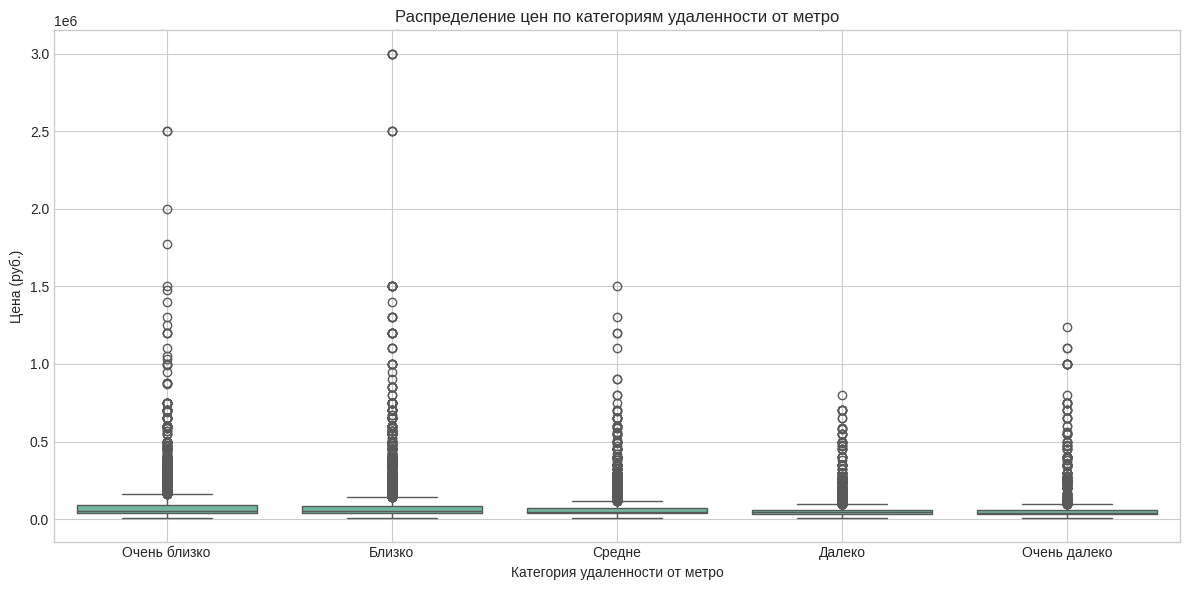

In [10]:
# Построим боксплот цены по категориям метро
plt.figure(figsize=(12, 6))
sns.boxplot(x='metro_category', y='price', data=df)
plt.title('Распределение цен по категориям удаленности от метро')
plt.xlabel('Категория удаленности от метро')
plt.ylabel('Цена (руб.)')
plt.xticks([0, 1, 2, 3, 4], ['Очень близко', 'Близко', 'Средне', 'Далеко', 'Очень далеко'])
plt.grid(True)
plt.tight_layout()
plt.savefig('../realises/metro_category_price.png', dpi=300)
plt.show()

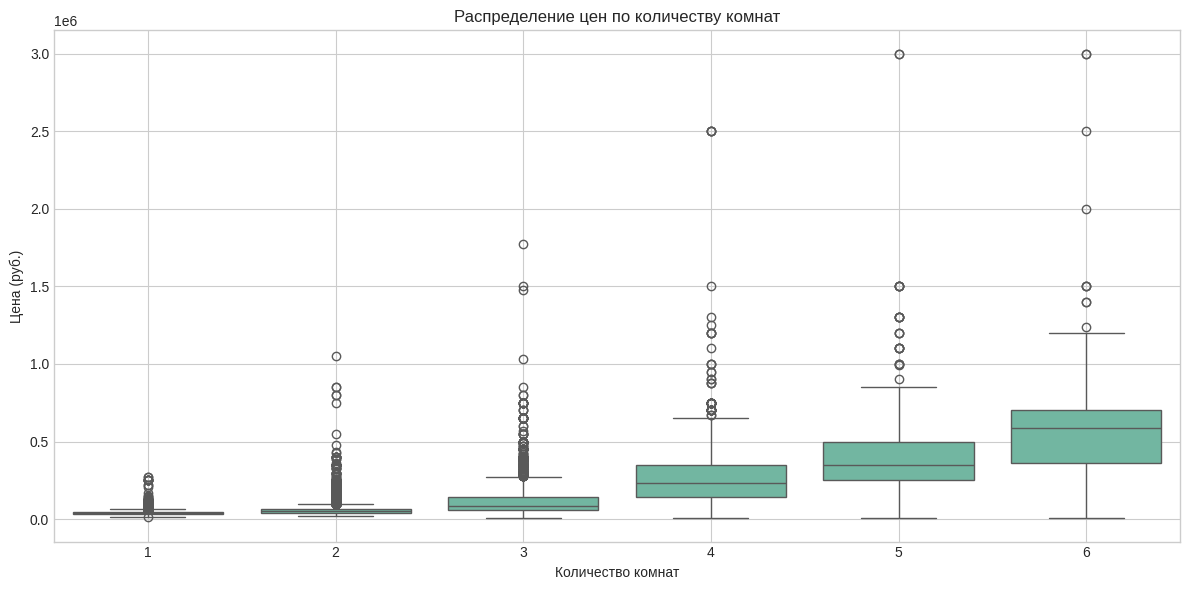

In [11]:
# Боксплот цены по количеству комнат
plt.figure(figsize=(12, 6))
sns.boxplot(x='number_of_rooms', y='price', data=df)
plt.title('Распределение цен по количеству комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Цена (руб.)')
plt.grid(True)
plt.tight_layout()
plt.savefig('../realises/rooms_price.png', dpi=300)
plt.show()

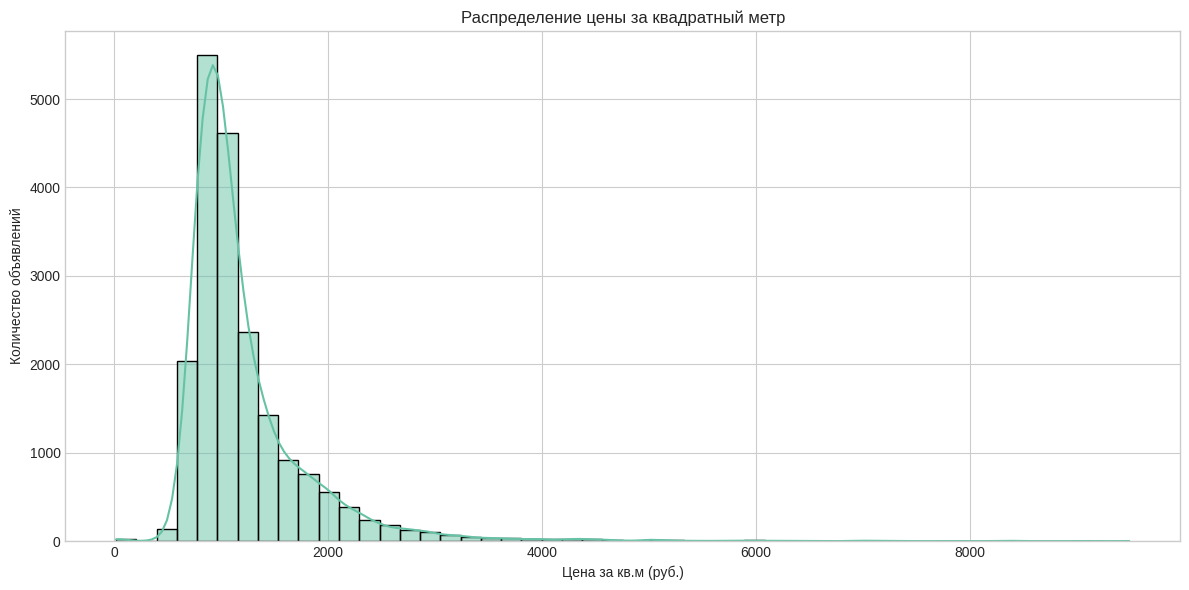

In [12]:
# Строим гистограмму цены за кв. метр
plt.figure(figsize=(12, 6))
sns.histplot(df['price_per_m2'], bins=50, kde=True)
plt.title('Распределение цены за квадратный метр')
plt.xlabel('Цена за кв.м (руб.)')
plt.ylabel('Количество объявлений')
plt.grid(True)
plt.tight_layout()
plt.savefig('../realises/price_per_m2_dist.png', dpi=300)
plt.show()

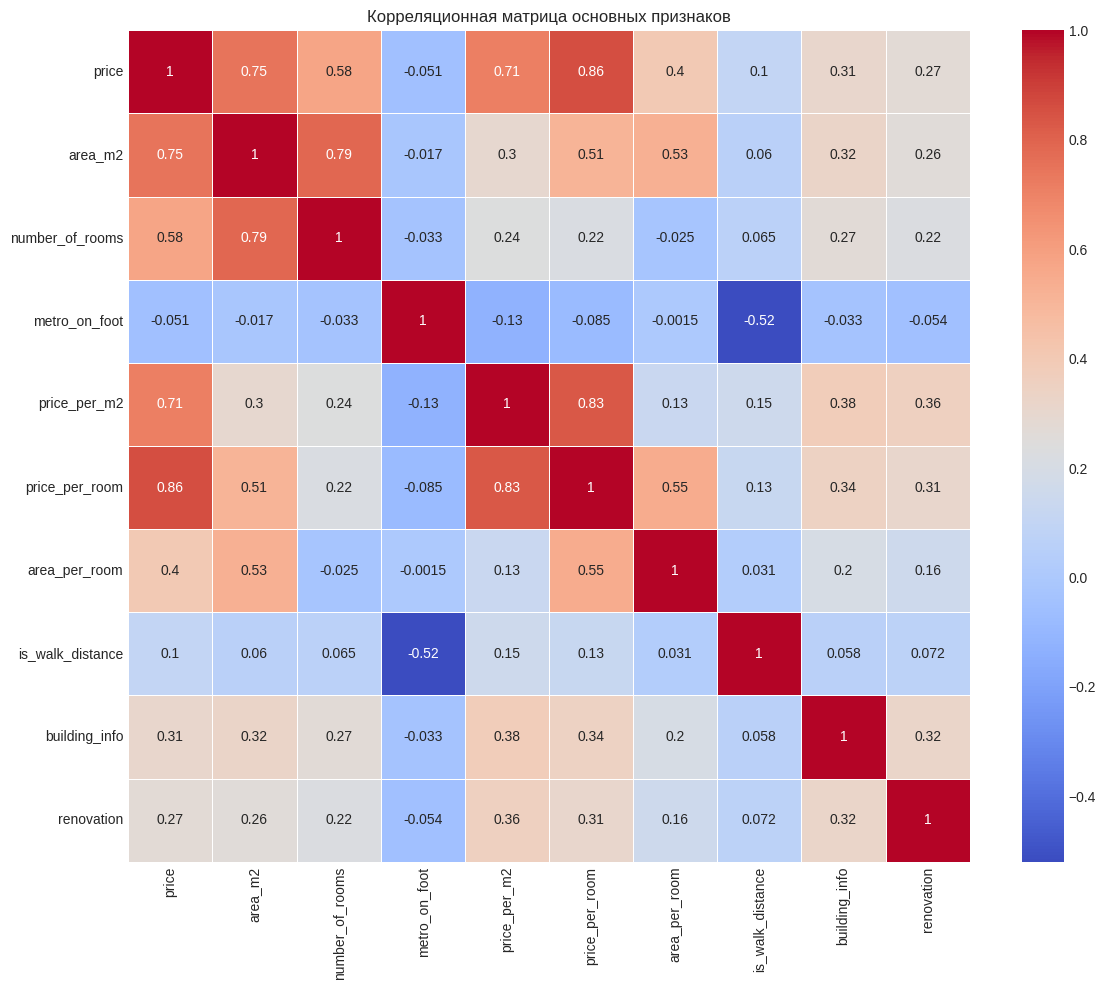

In [14]:
# Построим тепловую карту корреляций для основных признаков
important_features = ['price', 'area_m2', 'number_of_rooms', 'metro_on_foot', 'price_per_m2',
                     'price_per_room', 'area_per_room', 'is_walk_distance', 'building_info', 'renovation']
plt.figure(figsize=(12, 10))
sns.heatmap(df[important_features].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Корреляционная матрица основных признаков')
plt.tight_layout()
plt.savefig('../realises/correlation_matrix.png', dpi=300)
plt.show()

## 5. Сохранение результатов


In [19]:
# Сохраняем данные в CSV файл
df.to_csv('../data/SOLYaNKA.csv', index=False)

## 6. Выводы

В рамках этого ноутбука мы выполнили инженерию признаков для улучшения предсказания стоимости аренды квартир:

1. Создали признаки на основе цены:
   - price_per_m2 (цена за квадратный метр)
   - price_per_room (цена за комнату)

2. Преобразовали время до метро в категориальные признаки:
   - metro_category (категории удаленности)
   - is_walk_distance (в пешей доступности)

3. Создали признаки на основе площади:
   - is_small_area (маленькая квартира)
   - is_large_area (большая квартира)
   - area_per_room (площадь на комнату)

4. Создали категориальный признак цены:
   - price_category (бюджетное, среднее, дорогое, премиум)

5. Создали комбинированные признаки:
   - building_renovation (комбинация типа здания и ремонта)
   - metro_building (комбинация близости к метро и типа здания)

Все признаки выражены в числовом виде, что соответствует требованиям 3-го релиза. В данных нет дубликатов и отсутствуют пропущенные значения. Среди созданных признаков наиболее сильную корреляцию с ценой имеют цена за комнату, цена за квадратный метр и категория цены, что является ожидаемым результатом.

In [16]:
df.head(5)

,id_listing,number_of_rooms,metro_on_foot,area_m2,building_info,price,renovation,bathroom,price_per_m2,price_per_room,metro_category,is_walk_distance,is_small_area,is_large_area,area_per_room,price_category,building_renovation,metro_building
0,271271157,4,9,200,2,500000,3,0,2500.000000,125000.0,1,1,0,1,50.0,3,23,12
1,271634126,4,8,198,3,500000,3,1,2525.252525,125000.0,1,1,0,1,49.5,3,33,13
2,271173086,4,7,200,1,500000,2,1,2500.000000,125000.0,1,1,0,1,50.0,3,12,11
3,272197456,4,3,170,1,400000,2,1,2352.941176,100000.0,0,1,0,1,42.5,3,12,1
4,273614615,2,7,58,0,225000,2,0,3879.310345,112500.0,1,1,0,0,29.0,3,2,10
